# Movie Revenue and Profit Prediction 

This notebook works through classification models related to predicting the box office profit of movies released between 1995 and June 2018.  The related GitHub for this project is here: https://github.com/georgetown-analytics/Box-Office.  

The raw data sources were cleaned, wrangled, and had some pre-processing performed on them in separate python codes stored here: https://github.com/georgetown-analytics/Box-Office/tree/master/codes.  

The final dataset is stored in a SQLite database here: https://github.com/georgetown-analytics/Box-Office/tree/master/database.

This notebook is for the modeling stage of the project and includes classification models.

Author: Rebecca George.  Team Box Office: George Brooks, Rebecca George, Lance Liu

In [103]:
import warnings
warnings.filterwarnings('ignore')

In [95]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql
import sqlite3 as sql
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier)
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV, 
    LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV)
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.neural_network import MLPClassifier

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate, GridSearchCV

from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score,confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import preprocessing

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

from yellowbrick.classifier import ClassificationReport, ROCAUC, ConfusionMatrix
from yellowbrick.features import FeatureImportances

from imblearn.over_sampling import SMOTE
import os
from sklearn.tree import export_graphviz
import pydot

%matplotlib inline

Get path to folder storing the SQLite database

In [19]:
two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
path = two_up + '\database\movies.db'

In [20]:
con = sql.connect(path) 

data = pd_sql.read_sql('select * from finalMovies_20180814', con, index_col='index')



# Classification Models

We can try to develop classes of movies in order to use classification models.  So, this section will look at whether we can predict movie profitability.  We will use a feature we created during the pre-processing step: "Profit_Bucket", which indicates whether a movie made less than its budget, same as its budget, twice its budget, three times, etc.  The classes are: <1x, [1-2x), [2-3x), [3-4x), [4-5x), and >=5x.  

From this, we will create an additional feature called "Profit_Bucket_Binary" which will equal a 1 if the movie made at least twice its budget, and 0 if not.  We chose this threshold because in some of the literature regarding movie profitability, a rule-of-thumb some people follow is a movie likely makes a profit if it makes at least twice its production budget.  This is due to the extra costs of marketing, distribution, and other expenses.

Some of the codes to run models were taken from some labs we did in Dr. Bengfort's class.

### Create Profit Bucket Binary variable and set (X, y) train and test sets

We will create the new feature "Profit_Bucket_Binary", convert any "nan" in the historical cast/crew revenue columns to 0, and set the X and y variables that we will use for all the classification model testing. 

In [21]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in.  We could experiment with movies with revenue greater than $500,000, if 
#we choose to.
movies = data[(data['Revenue_Real']>0)&(data['Budget_Real']>0)&(data['Length']>0)]

#Make binary variable for if movie made at least 2x budget
movies['Profit_Bucket_Binary']=np.where(movies['Profit_Bucket']=='<1x', 0, np.where(movies['Profit_Bucket']=='[1-2x)', 
                        0, np.where(movies['Profit_Bucket']=='[2-3x)', 1, np.where(movies['Profit_Bucket']=='[3-4x)', 
                        1, np.where(movies['Profit_Bucket']=='[4-5x)', 1, np.where(movies['Profit_Bucket']=='>=5x', 1, ''))))))

#Put zero where null
movies['Revenue_Actor_Real']=movies['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
movies['Revenue_Director_Real']=movies['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
movies['Revenue_Writer_Real']=movies['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)


0    2539
1    1875
Name: Profit_Bucket_Binary, dtype: int64


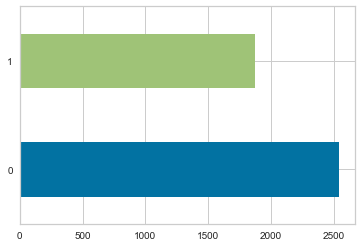

In [22]:
#Show distribution of profit bucket binary
print(movies['Profit_Bucket_Binary'].value_counts())
movies['Profit_Bucket_Binary'].value_counts().plot(kind='barh')
plt.show()

### As done in the Regression modeling Jupyter notebook, let's remove any Awards categories and imdbVotes, even though they are correlated with movie revenue.  

In [23]:
#Set X, y
X = movies[["Budget_Real", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real','Revenue_Director_Real', 'Revenue_Writer_Real']]
y = movies["Profit_Bucket_Binary"]

In [24]:
scaler = StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
X_std = min_max_scaler.fit_transform(X)

### Use YellowBrick Visualizations to get initial look at Classification Reports and ROC AUC curves
This is use a simple train/test split

In [25]:
seed=3
X_train_std, X_test_std, y_train_std, y_test_std = \
    cross_validation.train_test_split(X_std, y, test_size = 0.2, random_state=seed)

In [56]:
classifiers = [
    LogisticRegressionCV(random_state=1, cv=5), #, class_weight = 'balanced'),
    LogisticRegression(random_state=1), #, class_weight = 'balanced'),
    RandomForestClassifier(n_estimators=50, oob_score=True), #, class_weight = 'balanced'),
    XGBClassifier(),#scale_pos_weight = 1.35),   
    BaggingClassifier(), 
    ExtraTreesClassifier(),  #, class_weight = 'balanced'),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MultinomialNB(),
    GaussianNB(),
    SGDClassifier(), #, class_weight = 'balanced'), ##ROC AUC not printing out properly
    MLPClassifier(),
    SVC(kernel='linear'), #, class_weight = 'balanced'), ##ROC AUC not printing out properly
    SVC(kernel='rbf'), #, class_weight = 'balanced'),
    SVC(kernel='poly', degree=3), #, class_weight = 'balanced'),
    KNeighborsClassifier()
]

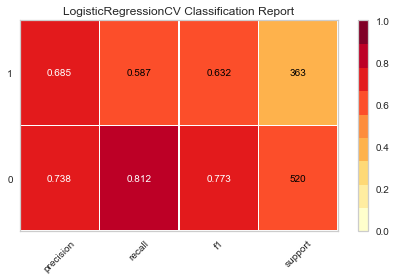

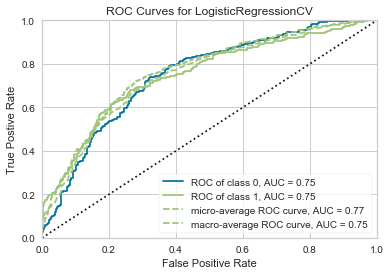

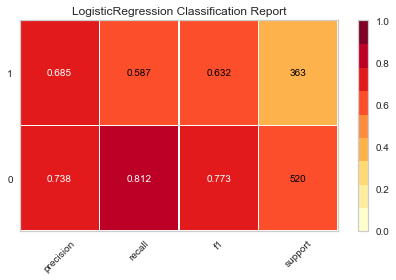

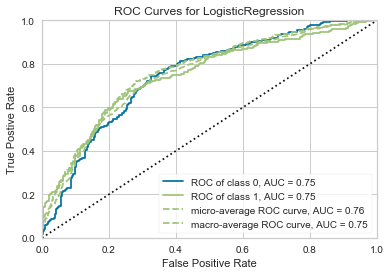

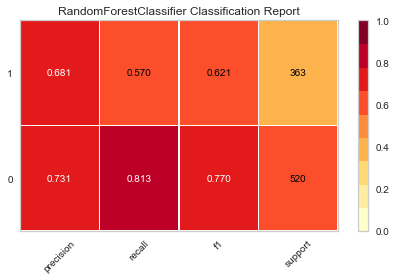

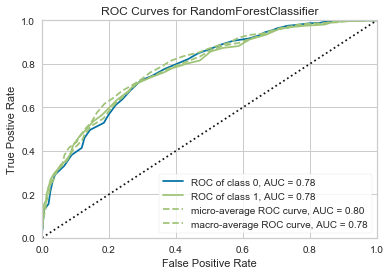

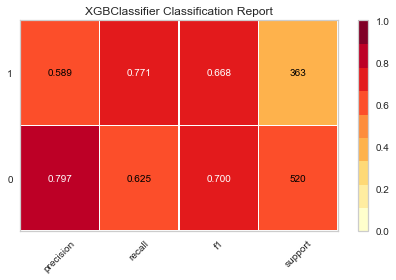

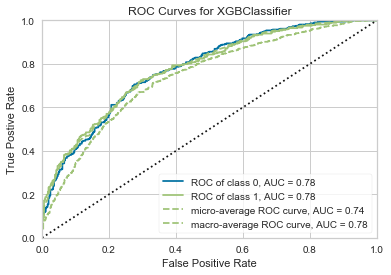

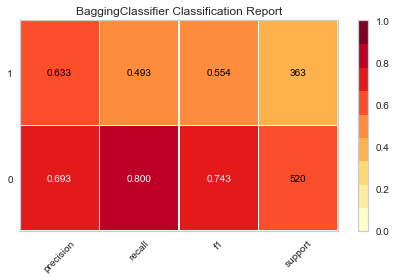

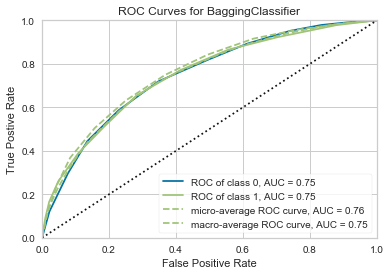

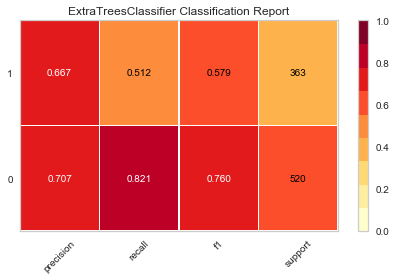

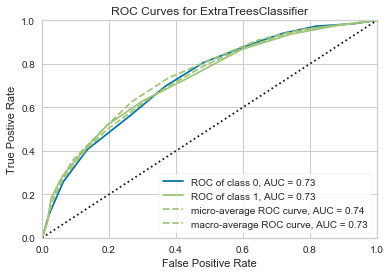

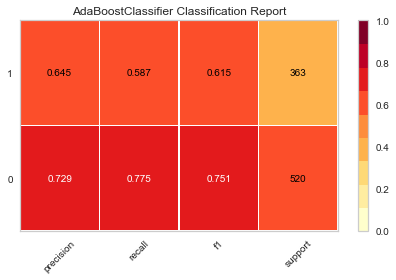

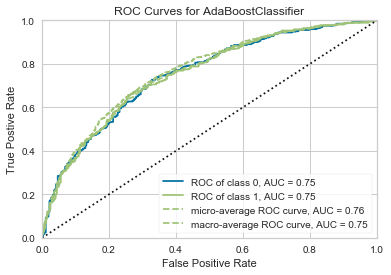

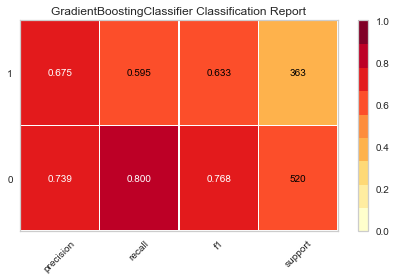

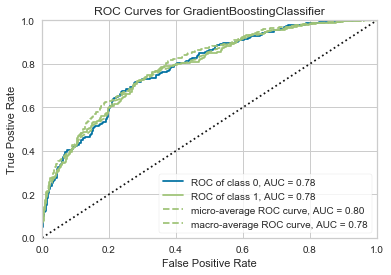

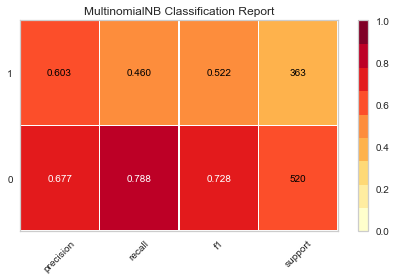

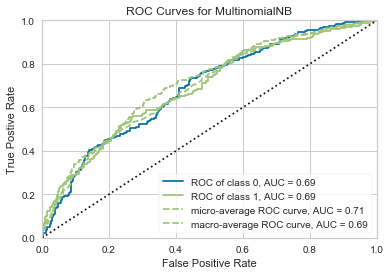

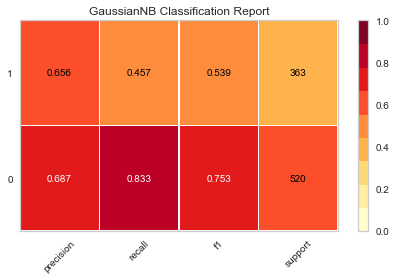

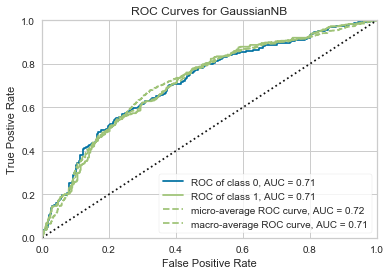

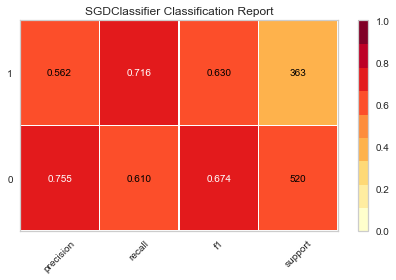

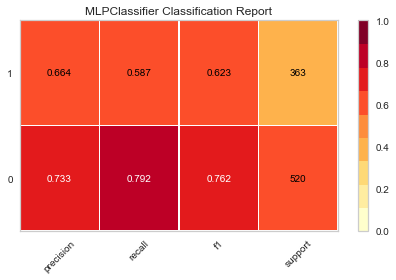

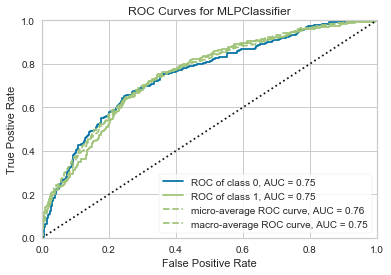

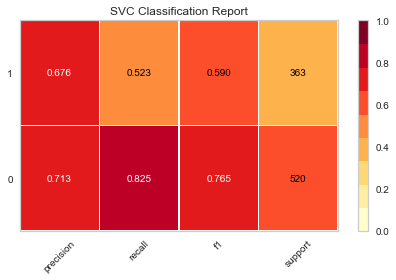

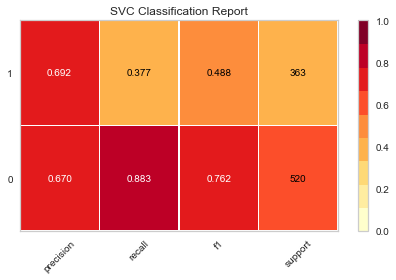

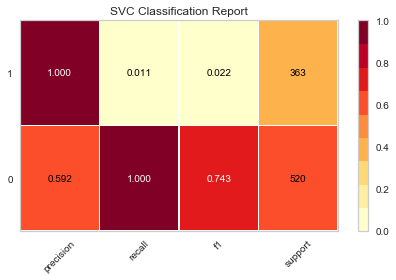

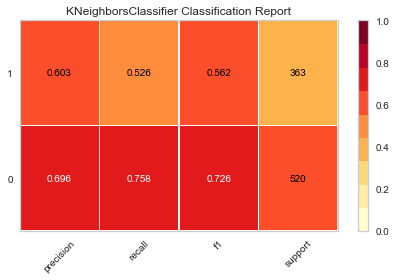

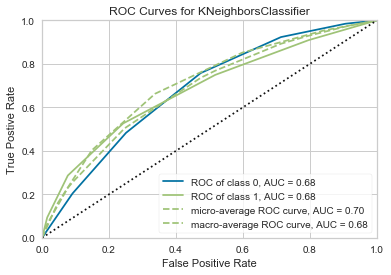

In [57]:
for clf in classifiers:

    name = clf.__class__.__name__
    
    oz = ClassificationReport(clf, support=True)
    oz.fit(X_train_std, y_train_std)
    oz.score(X_test_std, y_test_std)
    oz.poof()
    
    if name != "SGDClassifier" and name != "SVC":
        label_encoder = LabelEncoder()
        yc = label_encoder.fit_transform(y)
        oz = ROCAUC(clf, support=True, classes=label_encoder.classes_)
        oz.fit(X_train_std, y_train_std)
        oz.score(X_test_std, y_test_std)
        oz.poof()

    ###Other YellowBrick viz
    #oz=FeatureImportances(clf)
    #oz.fit(X_train, y_train)
    #oz.poof()
    

### Use K-fold cross validation to further examine some of the better models.
Based on the classification reports above, let's examine the better models.  Make the cutoff for models at least 0.60 F1 score for detecting a profitable movie (i.e, the Profit Bucket Binary variable = 1): Logistic Regression, Random Forest, XGBoost, AdaBoost, Gradient Boosting, MLP, SVC(rbf/linear). Keeping SVC because it was borderline ~0.59. Also adding Voting Classifier to see if it can do better by combing multiple models.

For each potential classification model and print out Accuracy, Precision, Recall, F1, ROC_AUC using k-fold cross validation.

In [60]:
#sm = SMOTE(random_state=12)
#X_std_SMOTE, y_SMOTE = sm.fit_sample(X_std, y)

In [104]:
classifiers = [
    LogisticRegressionCV(random_state=1, cv=5), #, class_weight = 'balanced'),
    LogisticRegression(random_state=1), #, class_weight = 'balanced'),
    RandomForestClassifier(n_estimators=50, oob_score=True), #, class_weight = 'balanced'),
    XGBClassifier(),#scale_pos_weight = 1.35),      
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    MLPClassifier(),
    SGDClassifier(),
    SVC(kernel='linear'), #, class_weight = 'balanced'), ##ROC AUC not printing out properly
    SVC(kernel='rbf'), #, class_weight = 'balanced'),
    VotingClassifier(estimators=[('lr', LogisticRegressionCV(random_state=1, cv=5)), 
                                 ('rf', RandomForestClassifier(n_estimators=50, oob_score=True)), 
                                 ('xbg', XGBClassifier()),
                                 ('ad', AdaBoostClassifier()), 
                                 ('gb', GradientBoostingClassifier()), 
                                 ('mlp', MLPClassifier())],
                                 #('sv', SVC(kernel='rbf'))],
                                voting='soft')
]

In [105]:
for clf in classifiers:

    name = clf.__class__.__name__
    y_int = y.astype(int)
    #y_int_SMOTE = y_SMOTE.astype(int)
    scoring_list = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    scores = cross_validate(clf, X_std, y_int, cv=10, scoring=scoring_list, return_train_score=False)  
    #scores_SMOTE = cross_validate(clf, X_std_SMOTE, y_int_SMOTE, cv=10, scoring=scoring_list, return_train_score=False)
    
    print(name, #'\t', '\t' , '\t' , '\t' ,'\t', name, "SMOTE",
          '\n', "\tAccuracy:",scores['test_accuracy'].mean(),
              #"\t\t\t\tAccuracy:",scores_SMOTE['test_accuracy'].mean(),
          '\n', "\tPrecision:", scores['test_precision'].mean(), 
              #"\t\t\t\tPrecision:", scores_SMOTE['test_precision'].mean(),
          '\n', "\tRecall:", scores['test_recall'].mean(), 
              #"\t\t\t\tRecall:", scores_SMOTE['test_recall'].mean(),
          '\n', "\tF1:", scores['test_f1'].mean(), 
              #"\t\t\t\t\tF1:", scores_SMOTE['test_f1'].mean(),
          '\n', "\tROC_AUC:", scores['test_roc_auc'].mean(), 
              #"\t\t\t\tROC_AUC:", scores_SMOTE['test_roc_auc'].mean(),
          '\n' 
         )    
    #y_pred = cross_val_predict(clf,X_std,y,cv=10)
    #class_report = classification_report(y,y_pred)
    #print(name, '\n', class_report)    

LogisticRegressionCV 
 	Accuracy: 0.7061308276224243 
 	Precision: 0.6928665131072772 
 	Recall: 0.5567612925247469 
 	F1: 0.6163978611473714 
 	ROC_AUC: 0.7653485484717406 

LogisticRegression 
 	Accuracy: 0.7083999473915441 
 	Precision: 0.6960145839320132 
 	Recall: 0.5605017635680964 
 	F1: 0.6199658945977727 
 	ROC_AUC: 0.7653048739303264 

RandomForestClassifier 
 	Accuracy: 0.7154284137897583 
 	Precision: 0.7088746465959734 
 	Recall: 0.5631357378541357 
 	F1: 0.6264281828151473 
 	ROC_AUC: 0.7825890712051864 

XGBClassifier 
 	Accuracy: 0.7208695762687359 
 	Precision: 0.7205401608394181 
 	Recall: 0.563155649106838 
 	F1: 0.6313246980310022 
 	ROC_AUC: 0.788004135395364 

AdaBoostClassifier 
 	Accuracy: 0.7142915487873471 
 	Precision: 0.6997704643890812 
 	Recall: 0.5796734554556833 
 	F1: 0.6327899528730555 
 	ROC_AUC: 0.7750202907020409 

GradientBoostingClassifier 
 	Accuracy: 0.7233546612118041 
 	Precision: 0.7197352986250662 
 	Recall: 0.5738053248378655 
 	F1: 0.63764

### A look at feature importances. 
For the classifiers that have the ability to give a ranking of feature importances, plot top 10 features.

In [48]:
classifiers = [
    LogisticRegressionCV(random_state=1, cv=5),
    LogisticRegression(random_state=1),
    RandomForestClassifier(n_estimators=50, oob_score=True),
    XGBClassifier(),  
    ExtraTreesClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(), 
    SVC(kernel='linear')
]

##Adapted code to determine most important feature from here:
##https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train_std, y_train_std)
    temp = pd.DataFrame(X_train_std, columns=X.columns)

    if name != "LogisticRegressionCV" and name != "LogisticRegression" and \
        name != "MultinomialNB" and name != "SGDClassifier" and \
        name != "SVC":
        feature_importances = pd.DataFrame(clf.feature_importances_,
           index = temp.columns,columns=['importance']).sort_values('importance',
            ascending=False)
        print(name, '\n',feature_importances.head(15))
        print('\n')
        
    elif name == "LogisticRegressionCV" or name == "LogisticRegression" or \
        name == "SGDClassifier" or name == "SVC":
        feature_importances = pd.DataFrame(clf.coef_.transpose(),
        index = temp.columns,columns=['importance']).sort_values('importance',
            ascending=False)
        print(name, '\n', feature_importances.abs().sort_values(by='importance', ascending=False).head(15))
        print('\n')        
        
    else:
        feature_importances = pd.DataFrame(clf.coef_.transpose(),
        index = temp.columns,columns=['importance']).sort_values('importance',
            ascending=False)
        print(name, '\n', feature_importances.head(15))
        print('\n')

LogisticRegressionCV 
                        importance
Rating_IMDB              2.160715
isCollection             1.690211
Comp_Disney              1.226569
Rating_RT                1.221678
Revenue_Director_Real    1.161104
Comp_Fox                 1.058121
Comp_Universal           0.678629
Comp_Sony                0.671670
Comp_Lionsgate           0.611309
Comp_Paramount           0.600126
Budget_Real              0.583579
Revenue_Actor_Real       0.565540
Genre_Drama              0.556704
Rating_Metacritic        0.545392
Revenue_Writer_Real      0.479345


LogisticRegression 
                        importance
Rating_IMDB              2.669534
isCollection             1.741558
Revenue_Director_Real    1.625936
Comp_Disney              1.378386
Rating_RT                1.264260
Comp_Fox                 1.128552
Budget_Real              1.068927
Revenue_Writer_Real      0.969965
Rated_Other              0.946697
Rated_R                  0.739620
Comp_Universal           0.739189
Co

### Next, perform hyperparameter tuning on some of the better models
See if classifiers perform better with tuning of hyperparameters.  We will then place some of the best ones into a Voting Classifier and have it decide the best combination of models.

Caution: The Gradient Booster and Voting Classifier grid searches take a few hours to run.

In [189]:
#SVC grid search

parameters = {'kernel':('linear', 'rbf', 'poly'), 
              'C':[1, 2,3,4,5,6,7,8,9, 10],
              'class_weight': [None, 'balanced']}

y_train_std_int = y_train_std.astype(int)
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for SVC:")
print()
print(clf.best_params_)

Best parameters set found for SVC:

{'C': 8, 'class_weight': 'balanced', 'kernel': 'rbf'}


In [84]:
#Random Forest grid search

parameters = {'n_estimators':(1,20,40,60,80,100), 
              'max_features':[None, 'auto', 'log2'], 
              'max_depth': [1,10,20], 
              'class_weight': [None, 'balanced'],
              'oob_score': [True, False]}

y_train_std_int = y_train_std.astype(int)
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for Random Forest:")
print()
print(clf.best_params_)

Best parameters set found for Random Forest:

{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 60, 'oob_score': False}


In [197]:
#Logistic Regression grid search

parameters = {'penalty':['l1', 'l2'], 
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': [None, 'balanced']}

y_train_std_int = y_train_std.astype(int)
lr = LogisticRegression(random_state=1)
clf = GridSearchCV(lr, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for Logistic Regression:")
print()
print(clf.best_params_)

Best parameters set found for Logistic Regression:

{'C': 10, 'class_weight': None, 'penalty': 'l1'}


In [82]:
#Ada Boost grid search

parameters = {'n_estimators':(1,20,40,60,80,100, 120, 140, 160)}

y_train_std_int = y_train_std.astype(int)
ad = AdaBoostClassifier()
clf = GridSearchCV(ad, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for AdaBoost:")
print()
print(clf.best_params_)

Best parameters set found for AdaBoost:

{'n_estimators': 120}


In [58]:
#XGBoost grid search

parameters = {'scale_pos_weight' : [1,1.35, 1.5, 2, 2.5, 3, 4]}

y_train_std_int = y_train_std.astype(int)
xgb = XGBClassifier()
clf = GridSearchCV(xgb, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for XGBoost:")
print()
print(clf.best_params_)

Best parameters set found for XGBoost:

{'scale_pos_weight': 2}


*******CAUTION: The next three grid searches take a long time to run.  Don't run unless you have several hours.

In [59]:
#Gradient Boosting grid search

parameters = {'n_estimators':(40,60,80,100, 120), 
              'max_features':[None, 'auto', 'log2'], 
              'max_depth': [1,3,5], 
              'loss' : ['deviance', 'exponential'],
             'criterion': ['friedman_mse', 'mse', 'mae']}

y_train_std_int = y_train_std.astype(int)
gb = GradientBoostingClassifier()
clf = GridSearchCV(gb, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for Gradient Boost:")
print()
print(clf.best_params_)

Best parameters set found for Gradient Boost:

{'criterion': 'friedman_mse', 'loss': 'exponential', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 120}


In [81]:
#Voting Classifier grid search #1

#For grid search on a voting classifier, I took a function from here: 
#https://markhneedham.com/blog/2017/12/10/scikit-learn-using-gridsearch-tune-hyper-parameters-votingclassifier/,
#in order to get all combinations of voting weights:
def combinations_on_off(num_classifiers):
    return [[int(x) for x in list("{0:0b}".format(i).zfill(num_classifiers))]
            for i in range(1, 2 ** num_classifiers)]

weights = combinations_on_off(6)

#Then test parameters like in previous grid searches.
parameters = {'voting':['hard', 'soft'], 
              'weights':weights}

y_train_std_int = y_train_std.astype(int)
vc = VotingClassifier(estimators=[('lr', LogisticRegressionCV(random_state=1, cv=5)), 
                                 ('rf', RandomForestClassifier(n_estimators=50, oob_score=True)), 
                                 ('xbg', XGBClassifier()),
                                 ('ad', AdaBoostClassifier()), 
                                 ('gb', GradientBoostingClassifier()), 
                                 ('mlp', MLPClassifier())])#,
                                 #('sv', SVC(kernel='rbf'))])
clf = GridSearchCV(vc, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for Voting Classifier:")
print()
print(clf.best_params_)

Best parameters set found for Voting Classifier:

{'voting': 'soft', 'weights': [0, 0, 1, 0, 1, 1]}


In [87]:
#Voting Classifier grid search #2

#Perform grid search again on Voting Classifier, except now use the grid search results
#from the individual models.
def combinations_on_off(num_classifiers):
    return [[int(x) for x in list("{0:0b}".format(i).zfill(num_classifiers))]
            for i in range(1, 2 ** num_classifiers)]

weights = combinations_on_off(7)

#Then test parameters like in previous grid searches.
parameters = {'voting':['hard', 'soft'], 
              'weights':weights}

y_train_std_int = y_train_std.astype(int)
vc = VotingClassifier(estimators=[('lrcv', LogisticRegressionCV(random_state=1, cv=5)), 
                                  ('lr', LogisticRegression(C= 10, class_weight= None, penalty= 'l1',random_state=1)),
                                 ('rf', RandomForestClassifier(class_weight= 'balanced', max_depth= 10, max_features= 'log2', n_estimators= 60, oob_score=False)), 
                                 ('xbg', XGBClassifier(scale_pos_weight= 2)),
                                 ('ad', AdaBoostClassifier(n_estimators= 120)), 
                                 ('gb', GradientBoostingClassifier(criterion= 'friedman_mse', loss= 'exponential', max_depth= 5, max_features= 'log2', n_estimators= 120)), 
                                 ('mlp', MLPClassifier())])#,
                                 #('sv', SVC(kernel='rbf'))])
clf = GridSearchCV(vc, parameters, scoring='f1')
clf.fit(X_train_std, y_train_std_int)

print("Best parameters set found for Voting Classifier:")
print()
print(clf.best_params_)

Best parameters set found for Voting Classifier:

{'voting': 'hard', 'weights': [0, 0, 1, 1, 0, 0, 1]}


### Print out classification report and confusion matrix for Voting Classifier
Use the hyperparameter tuning results as the parameters for the voting classifier

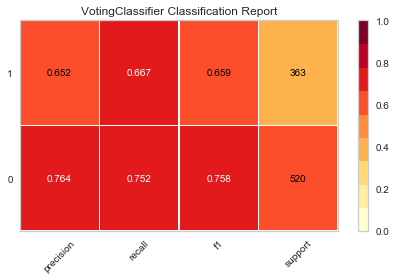

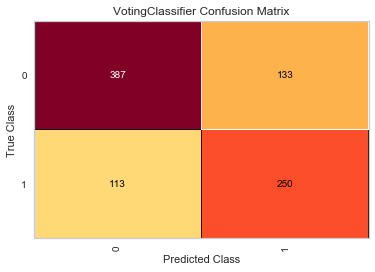

In [93]:
vc_final = VotingClassifier(estimators=[('lrcv', LogisticRegressionCV(random_state=1, cv=5)), 
                                  ('lr', LogisticRegression(C= 10, class_weight= None, penalty= 'l1',random_state=1)),
                                 ('rf', RandomForestClassifier(class_weight= 'balanced', max_depth= 10, max_features= 'log2', n_estimators= 60, oob_score=False)), 
                                 ('xbg', XGBClassifier(scale_pos_weight= 2)),
                                 ('ad', AdaBoostClassifier(n_estimators= 120)), 
                                 ('gb', GradientBoostingClassifier(criterion= 'friedman_mse', loss= 'exponential', max_depth= 5, max_features= 'log2', n_estimators= 120)), 
                                 ('mlp', MLPClassifier())], 
                     weights = [0, 0, 1, 1, 0, 0, 1],
                     voting = 'hard')


name = vc_final.__class__.__name__

oz = ClassificationReport(vc_final, support=True)
oz.fit(X_train_std, y_train_std)
oz.score(X_test_std, y_test_std)
oz.poof()

oz = ConfusionMatrix(vc_final)
oz.fit(X_train_std, y_train_std)
oz.score(X_test_std, y_test_std)
oz.poof()

##ROC AUC not working
#label_encoder = LabelEncoder()
#yc = label_encoder.fit_transform(y)
##oz = ROCAUC(vc, support=True, classes=label_encoder.classes_)
#oz.fit(X_train_std, y_train_std)
#oz.score(X_test_std, y_test_std)
#oz.poof()


### Pick the Voting Classifier and save it as final classification model

Store final model in GitHub folder called "final_model"

In [102]:
##Code to store lasso model in GitHub.  Commented out to prevent writing over current model.
#two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
#filename = two_up + r'\final_models\votingClassifier_20180901.pkl'
#joblib.dump(vc_final, filename)

VotingClassifier(estimators=[('lrcv', LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=1,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard',
         weights=[0, 0, 1, 1, 0, 0, 1])


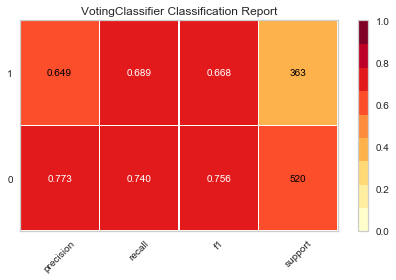

In [101]:
#Code to double check stored Voting Classifier model is the same as what was created above.

two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
filename = two_up + r'\final_models\votingClassifier_20180901.pkl'
vc_check = joblib.load(filename)
print(vc_check)
oz = ClassificationReport(vc_check, support=True)
oz.fit(X_train_std, y_train_std)
oz.score(X_test_std, y_test_std)
oz.poof()